In [238]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2
import csv
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
from sklearn.model_selection import train_test_split

In [239]:
print("Tensorflow version", tf.__version__)

Tensorflow version 1.11.0


In [240]:
data = pd.read_csv('/Users/gali/Downloads/traffic_sign_german/data/TrainIJCNN2013/gt.txt', sep=";", header=None)
data.columns = ["img", "x1", "y1", "x2", "y2", "id"]
# print(data.values)



#################################
###DATA AUGMENTATION FUNCTIONS###
#################################

def random_rotation(image_array):
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array):
    return sk.util.random_noise(image_array)


def add_brightness(image):
    image = image.astype(np.uint8)
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    random_brightness_coefficient = np.random.uniform()+0.5 ## generates value between 0.5 and 1.5
    image_HLS[:,:,1] = image_HLS[:,:,1]*random_brightness_coefficient ## scale pixel values up or down for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def add_snow(image):
    image = image.astype(np.uint8)
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    brightness_coefficient = 1.5 
    snow_point=140 ## increase this for more snow
    image_HLS[:,:,1][image_HLS[:,:,1]<snow_point] = image_HLS[:,:,1][image_HLS[:,:,1]<snow_point]*brightness_coefficient ## scale pixel values up for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def generate_random_lines(imshape,slant,drop_length):
    drops=[]
    for i in range(1): ## If You want heavy rain, try increasing this
        if slant<0:
            x= np.random.randint(slant,imshape[1])
        else:
            x= np.random.randint(0,imshape[1]-slant)
        y= np.random.randint(0,imshape[0]-drop_length)
        drops.append((x,y))
    return drops
        
    
def add_rain(image):
    imshape = image.shape
    slant_extreme=10
    slant= np.random.randint(-slant_extreme,slant_extreme) 
    drop_length=20
    drop_width=2
    drop_color=(200,200,200) ## a shade of gray
    rain_drops= generate_random_lines(imshape,slant,drop_length)
    
    for rain_drop in rain_drops:
        cv2.line(image,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),drop_color,drop_width)
    image= cv2.blur(image,(7,7)) ## rainy view are blurry
    
    brightness_coefficient = 0.7 ## rainy days are usually shady 
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS[:,:,1] = image_HLS[:,:,1]*brightness_coefficient ## scale pixel values down for channel 1(Lightness)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

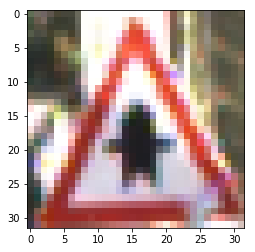

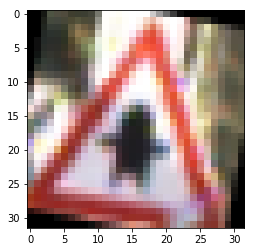

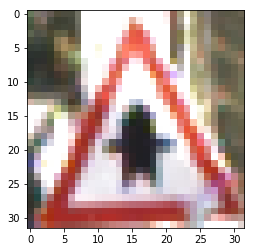

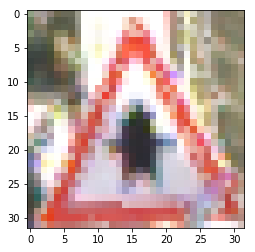

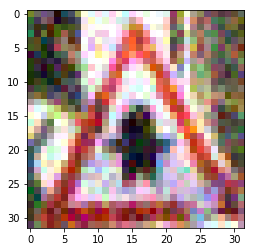

53676


In [241]:
# Populating train data

train_images = []
train_labels = []
for row in data.values:
    image_name = row[0]
    x1 = row[1]
    y1 = row[2]
    x2 = row[3]
    y2 = row[4]
    label = row[5]
    if int(label) in set([0,1,2,3,4,5,6,7,8,9,10,15,16]):
        label = 1
    else:
        label = 0

    image = misc.imread('/Users/gali/Downloads/traffic_sign_german/data/TrainIJCNN2013/'+ image_name)
    image = image[y1:y2, x1:x2]
    image = cv2.resize(image, (32, 32))
    train_images.append(image)
    train_labels.append(label)
    
    #####################
    # Data Augmentation #
    #####################
    
    # Do random rotations & add random noise
    for i in range(10):
        rotated_image = random_rotation(image)
        train_images.append(rotated_image)
        train_labels.append(label)
        train_images.append(add_brightness(rotated_image))
        train_labels.append(label)
        train_images.append(add_snow(rotated_image))
        train_labels.append(label)

        
        noise_image = random_noise(image)
        train_images.append(noise_image)
        train_labels.append(label)
        train_images.append(add_brightness(noise_image))
        train_labels.append(label)
        train_images.append(add_snow(noise_image))
        train_labels.append(label)
    
    # Do a horizontal flip
    train_images.append(add_brightness(image))
    train_labels.append(label)
    train_images.append(add_snow(image))
    train_labels.append(label)
#     print("--")
# print("end")

fig = plt.figure()
plt.imshow(train_images[0])
plt.show()
fig = plt.figure()
plt.imshow(random_rotation(train_images[0]))
plt.show()
fig = plt.figure()
plt.imshow(add_brightness(train_images[0]))
plt.show()
fig = plt.figure()
plt.imshow(add_snow(train_images[0]))
plt.show()
fig = plt.figure()
plt.imshow(random_noise(train_images[0]))
plt.show()
print(len(train_images))

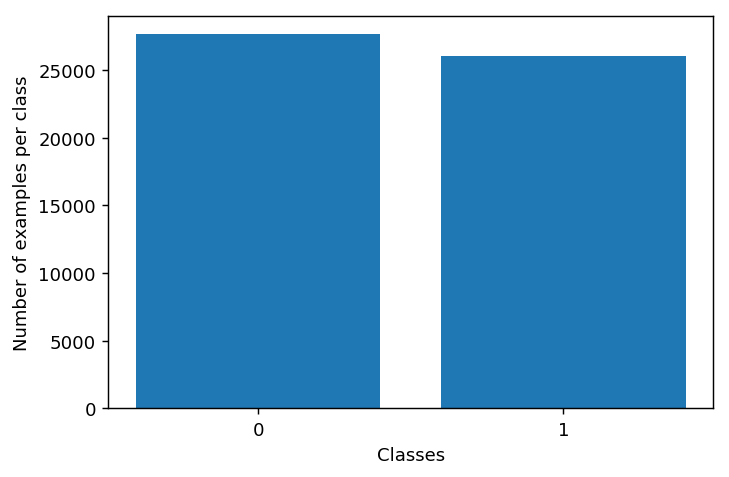

Number of test images 53676


In [242]:
# Number of samples per class
fig = plt.figure()
fig.set_dpi(130)
plt.bar([0,1],[train_labels.count(0), train_labels.count(1)])
plt.xlabel('Classes')
plt.xticks(range(0,2,1))
plt.ylabel('Number of examples per class')
plt.show()

# Populate the test data
test_images = []
test_dir_path = '/Users/gali/Downloads/traffic_sign_german/data/TestIJCNN2013Download/'
for f in os.listdir(test_dir_path):
    if os.path.isfile(os.path.join(test_dir_path, f)) and f.endswith('.ppm'):
        image = misc.imread(os.path.join(test_dir_path, f))
        test_images.append(image)
print("Number of test images", len(train_images))

In [243]:
print("Train has image files with traffic signs numbers:", len(data['img'].unique()))
print("Train has traffic signs class numbers:", len(data['id'].unique()))
print("Train has traffic signs instance numbers:", data['id'].count())

Train has image files with traffic signs numbers: 506
Train has traffic signs class numbers: 43
Train has traffic signs instance numbers: 852


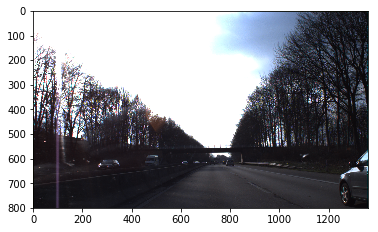

(800, 1360, 3)


In [244]:
# Sample plot of a test image
fig = plt.figure()
plt.imshow(test_images[1])
plt.show()
print(test_images[0].shape)